In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Import Necessary Module

In [ ]:
import tensorflow as tf
from keras.layers import Input, Flatten, Dense
from keras.models import Model
from keras.applications import VGG19, ResNet50
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import InceptionV3

2024-04-21 07:32:41.565821: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-21 07:32:41.565910: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-21 07:32:41.657948: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Read The Dataset

In [ ]:
train_dir = 'https://drive.google.com/drive/folders/18JJBkz1hv-MHlOtm31qnZX7sv82hCqbm?usp=sharing'
test_dir = 'https://drive.google.com/drive/folders/1Bg5RxmPaljz0lwbOtgaNU-wkTvDCGF4E?usp=sharing'


# Resize dataset picture

In [ ]:
image_size = (224, 224)
batch_size = 32

# Data augmentation and normalization

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load the training and test datasets

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 17117 images belonging to 5 classes.


In [ ]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)


Found 4280 images belonging to 5 classes.


# Function to visualize sample images

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
def visualize_images(generator):
    plt.figure(figsize=(10, 10))
    for images, labels in generator:
        for i in range(min(len(images), 9)):
            ax = plt.subplot(3, 3, i + 1)
            image = images[i]
            image = (image * 255).astype(np.uint8)  #

            plt.imshow(image)
            plt.title(np.argmax(labels[i]))
            plt.axis("off")
        break
    plt.show()
visualize_images(train_generator)

# Checking Imbalance class

In [ ]:
def check_class_imbalance(generator):
    num_samples = generator.samples
    class_indices = generator.class_indices
    num_classes = len(class_indices)
    class_counts = {class_idx: 0 for class_idx in range(num_classes)}
    for _, class_idx in generator.classes:
        class_counts[class_idx] += 1
    class_frequencies = {class_idx: count / num_samples for class_idx, count in class_counts.items()}

    return class_counts, class_frequencies

In [ ]:
train_class_counts, train_class_frequencies = check_class_imbalance(train_generator)
test_class_counts, test_class_frequencies = check_class_imbalance(test_generator)

In [ ]:
print("Training Data Class Imbalance:")
print(train_class_counts)
print("Training Data Class Frequencies:")
print(train_class_frequencies)

print("Test Data Class Imbalance:")
print(test_class_counts)
print("Test Data Class Frequencies:")
print(test_class_frequencies)

# Model Train

VGG19 Model

In [ ]:
def build_vgg19():
    base_model = VGG19(input_shape=(image_size[0], image_size[1], 3), weights='imagenet', include_top=False)
    for layer in base_model.layers:
        layer.trainable = False
    x = Flatten()(base_model.output)
    x = Dense(512, activation='relu')(x)
    outputs = Dense(len(train_generator.class_indices), activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    return model


In [ ]:
# Compile and train VGG19
vgg19_model = build_vgg19()
vgg19_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
vgg19_history = vgg19_model.fit(train_generator, validation_data=test_generator, epochs=25)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/25


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/535 ━━━━━━━━━━━━━━━━━━━━ 5:27:31 37s/step - accuracy: 0.1562 - loss: 2.5532

I0000 00:00:1713684835.545040     101 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1713684835.565600     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


271/535 ━━━━━━━━━━━━━━━━━━━━ 3:17 747ms/step - accuracy: 0.5927 - loss: 2.6487

W0000 00:00:1713685037.191527     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 679ms/step - accuracy: 0.6193 - loss: 1.9582

W0000 00:00:1713685200.318700     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


535/535 ━━━━━━━━━━━━━━━━━━━━ 475s 821ms/step - accuracy: 0.6194 - loss: 1.9567 - val_accuracy: 0.6673 - val_loss: 0.8972
Epoch 2/25


W0000 00:00:1713685273.886477     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


535/535 ━━━━━━━━━━━━━━━━━━━━ 241s 445ms/step - accuracy: 0.6888 - loss: 0.8445 - val_accuracy: 0.6876 - val_loss: 0.8593
Epoch 3/25
535/535 ━━━━━━━━━━━━━━━━━━━━ 238s 440ms/step - accuracy: 0.7040 - loss: 0.8042 - val_accuracy: 0.6871 - val_loss: 0.8554
Epoch 4/25
535/535 ━━━━━━━━━━━━━━━━━━━━ 242s 446ms/step - accuracy: 0.7110 - loss: 0.7867 - val_accuracy: 0.7005 - val_loss: 0.8022
Epoch 5/25
535/535 ━━━━━━━━━━━━━━━━━━━━ 239s 442ms/step - accuracy: 0.7244 - loss: 0.7524 - val_accuracy: 0.6575 - val_loss: 0.9042
Epoch 6/25
535/535 ━━━━━━━━━━━━━━━━━━━━ 242s 447ms/step - accuracy: 0.7303 - loss: 0.7371 - val_accuracy: 0.6977 - val_loss: 0.8214
Epoch 7/25
535/535 ━━━━━━━━━━━━━━━━━━━━ 240s 444ms/step - accuracy: 0.7379 - loss: 0.7130 - val_accuracy: 0.6946 - val_loss: 0.8577
Epoch 8/25
535/535 ━━━━━━━━━━━━━━━━━━━━ 239s 442ms/step - accuracy: 0.7491 - loss: 0.6878 - val_accuracy: 0.7000 - val_loss: 0.8305
Epoch 9/25
535/535 ━━━━━━━━━━━━━━━━━━━━ 239s 442ms/step - accuracy: 0.7470 - loss: 0.68

RestNet50 Model

In [ ]:
def build_resnet50():
    base_model = ResNet50(input_shape=(image_size[0], image_size[1], 3), weights='imagenet', include_top=False)
    for layer in base_model.layers:
        layer.trainable = False
    x = Flatten()(base_model.output)
    x = Dense(512, activation='relu')(x)
    outputs = Dense(len(train_generator.class_indices), activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    return model


In [ ]:
# Compile and train ResNet50
resnet50_model = build_resnet50()
resnet50_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
resnet50_history = resnet50_model.fit(train_generator, validation_data=test_generator, epochs=25)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/25
  2/535 ━━━━━━━━━━━━━━━━━━━━ 51s 96ms/step - accuracy: 0.2578 - loss: 11.7056  

W0000 00:00:1713691084.518155     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


287/535 ━━━━━━━━━━━━━━━━━━━━ 1:47 433ms/step - accuracy: 0.4992 - loss: 3.9810

W0000 00:00:1713691208.172062     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.5208 - loss: 3.0426

W0000 00:00:1713691311.246224     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


535/535 ━━━━━━━━━━━━━━━━━━━━ 271s 472ms/step - accuracy: 0.5209 - loss: 3.0402 - val_accuracy: 0.5904 - val_loss: 1.1465
Epoch 2/25


W0000 00:00:1713691336.814470     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


535/535 ━━━━━━━━━━━━━━━━━━━━ 237s 437ms/step - accuracy: 0.6060 - loss: 1.1631 - val_accuracy: 0.6224 - val_loss: 1.0857
Epoch 3/25
535/535 ━━━━━━━━━━━━━━━━━━━━ 235s 433ms/step - accuracy: 0.6158 - loss: 1.1210 - val_accuracy: 0.6255 - val_loss: 1.1284
Epoch 4/25
535/535 ━━━━━━━━━━━━━━━━━━━━ 234s 433ms/step - accuracy: 0.6234 - loss: 1.0953 - val_accuracy: 0.6194 - val_loss: 1.0831
Epoch 5/25
535/535 ━━━━━━━━━━━━━━━━━━━━ 237s 437ms/step - accuracy: 0.6216 - loss: 1.0847 - val_accuracy: 0.6159 - val_loss: 1.0704
Epoch 6/25
535/535 ━━━━━━━━━━━━━━━━━━━━ 237s 438ms/step - accuracy: 0.6236 - loss: 1.0790 - val_accuracy: 0.6241 - val_loss: 1.1216
Epoch 7/25
535/535 ━━━━━━━━━━━━━━━━━━━━ 237s 438ms/step - accuracy: 0.6152 - loss: 1.0903 - val_accuracy: 0.6192 - val_loss: 1.1176
Epoch 8/25
535/535 ━━━━━━━━━━━━━━━━━━━━ 235s 433ms/step - accuracy: 0.6274 - loss: 1.0620 - val_accuracy: 0.6222 - val_loss: 1.0585
Epoch 9/25
535/535 ━━━━━━━━━━━━━━━━━━━━ 235s 434ms/step - accuracy: 0.6200 - loss: 1.08

InceptionV3 Model

In [ ]:
def build_inceptionv3():

    base_model = InceptionV3(input_shape=(image_size[0], image_size[1], 3), weights='imagenet', include_top=False)
    for layer in base_model.layers:
        layer.trainable = False
    x = Flatten()(base_model.output)
    x = Dense(512, activation='relu')(x)
    outputs = Dense(len(train_generator.class_indices), activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    return model

In [ ]:
# Compile and train InceptionV3
inceptionv3_model = build_inceptionv3()
inceptionv3_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
inceptionv3_history = inceptionv3_model.fit(train_generator, validation_data=test_generator, epochs=25)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/25
  2/535 ━━━━━━━━━━━━━━━━━━━━ 55s 104ms/step - accuracy: 0.2734 - loss: 16.7007 

W0000 00:00:1713697052.367775     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


188/535 ━━━━━━━━━━━━━━━━━━━━ 2:48 484ms/step - accuracy: 0.5440 - loss: 11.0268

W0000 00:00:1713697142.835314     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.5929 - loss: 5.6463

W0000 00:00:1713697292.049448      99 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


535/535 ━━━━━━━━━━━━━━━━━━━━ 298s 510ms/step - accuracy: 0.5930 - loss: 5.6395 - val_accuracy: 0.6829 - val_loss: 0.8444
Epoch 2/25


W0000 00:00:1713697324.843562     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


535/535 ━━━━━━━━━━━━━━━━━━━━ 241s 445ms/step - accuracy: 0.6941 - loss: 0.8302 - val_accuracy: 0.6944 - val_loss: 0.8476
Epoch 3/25
535/535 ━━━━━━━━━━━━━━━━━━━━ 245s 453ms/step - accuracy: 0.7028 - loss: 0.8104 - val_accuracy: 0.6876 - val_loss: 0.8341
Epoch 4/25
535/535 ━━━━━━━━━━━━━━━━━━━━ 244s 450ms/step - accuracy: 0.7118 - loss: 0.7858 - val_accuracy: 0.6736 - val_loss: 0.8655
Epoch 5/25
535/535 ━━━━━━━━━━━━━━━━━━━━ 241s 445ms/step - accuracy: 0.7176 - loss: 0.7621 - val_accuracy: 0.6764 - val_loss: 0.8597
Epoch 6/25
535/535 ━━━━━━━━━━━━━━━━━━━━ 243s 450ms/step - accuracy: 0.7262 - loss: 0.7502 - val_accuracy: 0.6857 - val_loss: 0.8271
Epoch 7/25
535/535 ━━━━━━━━━━━━━━━━━━━━ 245s 452ms/step - accuracy: 0.7262 - loss: 0.7376 - val_accuracy: 0.6867 - val_loss: 0.8274
Epoch 8/25
535/535 ━━━━━━━━━━━━━━━━━━━━ 262s 452ms/step - accuracy: 0.7284 - loss: 0.7412 - val_accuracy: 0.6860 - val_loss: 0.8469
Epoch 9/25
535/535 ━━━━━━━━━━━━━━━━━━━━ 244s 451ms/step - accuracy: 0.7421 - loss: 0.71

# Plot The Model Report

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

# Function to plot training history
def plot_training_history(history, metric='accuracy'):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric])
    plt.title('Model ' + metric)
    plt.ylabel(metric)
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()


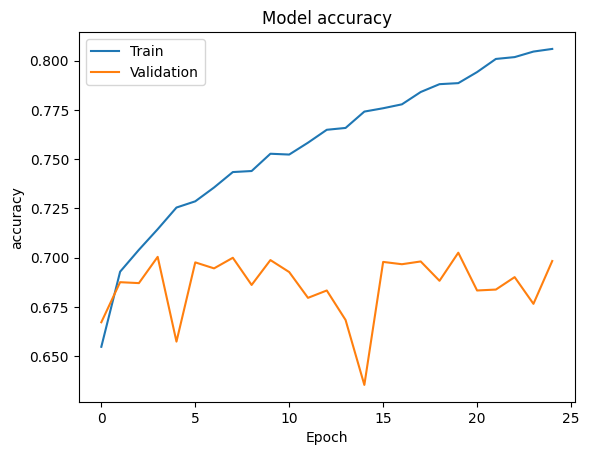

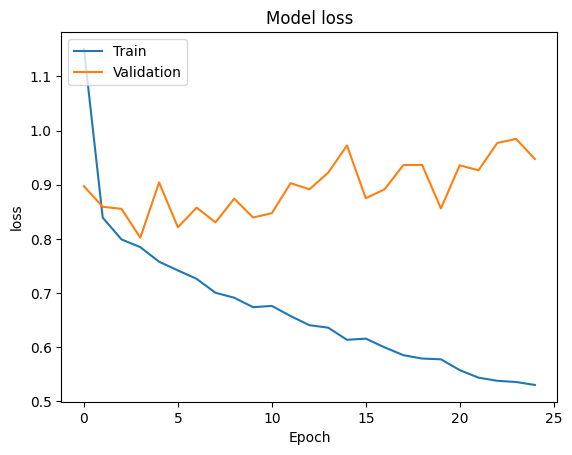

In [ ]:
# Plot training history for VGG19
plot_training_history(vgg19_history, metric='accuracy')
plot_training_history(vgg19_history, metric='loss')

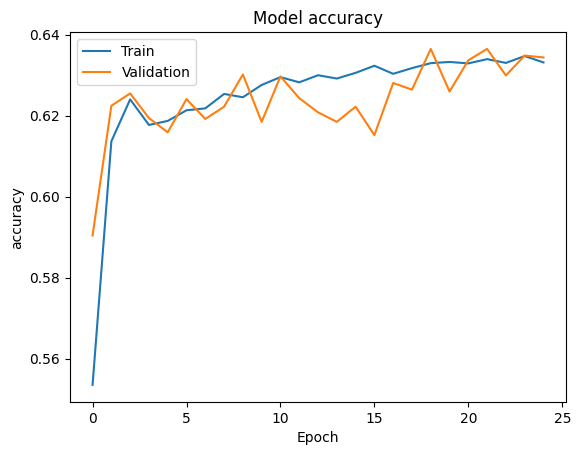

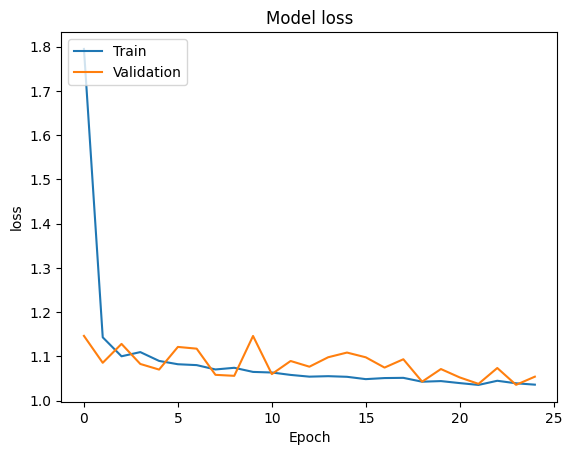

In [ ]:
# Plot training history for ResNet50
plot_training_history(resnet50_history, metric='accuracy')
plot_training_history(resnet50_history, metric='loss')

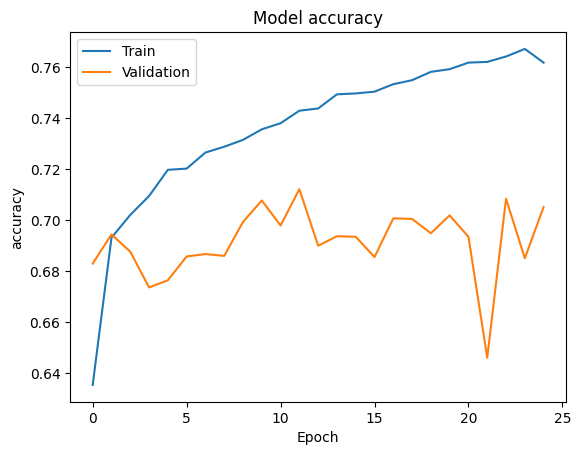

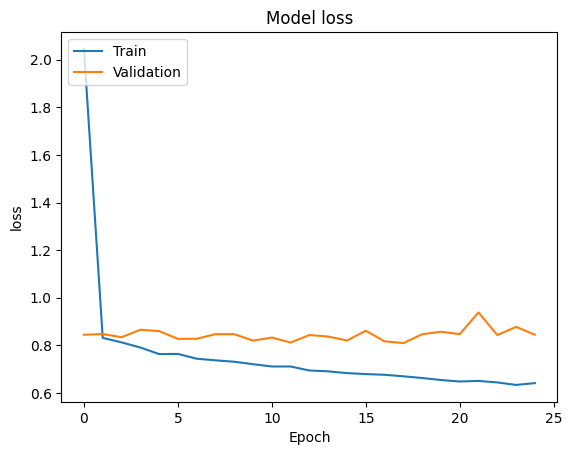

In [ ]:
# Plot training history for InceptionV3
plot_training_history(inceptionv3_history, metric='accuracy')
plot_training_history(inceptionv3_history, metric='loss')

# Classification Report

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

def print_classification_report(model, test_generator):
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = test_generator.classes
    print('Classification Report:')
    print(classification_report(y_true, y_pred_classes))

In [ ]:
# Print classification report for VGG19 model
print('Classification Report for VGG19 model:')
print_classification_report(vgg19_model, test_generator)

Evaluation for VGG19 model:
  2/134 ━━━━━━━━━━━━━━━━━━━━ 24s 187ms/step 

W0000 00:00:1713703108.920669      99 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


134/134 ━━━━━━━━━━━━━━━━━━━━ 24s 172ms/step
Accuracy: 0.4308411214953271
Precision: 0.40988736816735766
Recall: 0.43084112149532716
F1 Score: 0.41932373716099997
Classification Report:
              precision    recall  f1-score   support

           0       0.04      0.05      0.05       217
           1       0.10      0.07      0.08       438
           2       0.11      0.08      0.09       477
           3       0.61      0.65      0.63      2632
           4       0.10      0.10      0.10       516

    accuracy                           0.43      4280
   macro avg       0.19      0.19      0.19      4280
weighted avg       0.41      0.43      0.42      4280

Confusion Matrix:
[[  11   11   13  151   31]
 [  29   30   37  284   58]
 [  25   29   37  319   67]
 [ 169  194  210 1713  346]
 [  29   45   40  349   53]]


W0000 00:00:1713703131.753412     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [ ]:
# Print classification report for ResNet50 model
print('Classification Report for ResNet50 model:')
print_classification_report(resnet50_model, test_generator)

Evaluation for ResNet50 model:
  2/134 ━━━━━━━━━━━━━━━━━━━━ 11s 90ms/step

W0000 00:00:1713703136.031152     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


134/134 ━━━━━━━━━━━━━━━━━━━━ 26s 167ms/step
Accuracy: 0.5418224299065421
Precision: 0.38843134705557986
Recall: 0.5418224299065421
F1 Score: 0.45248031159154983
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       217
           1       0.10      0.13      0.11       438
           2       0.00      0.00      0.00       477
           3       0.62      0.86      0.72      2632
           4       0.00      0.00      0.00       516

    accuracy                           0.54      4280
   macro avg       0.14      0.20      0.17      4280
weighted avg       0.39      0.54      0.45      4280

Confusion Matrix:
[[   0   27    0  190    0]
 [   0   59    0  379    0]
 [   0   77    0  400    0]
 [   0  371    0 2260    1]
 [   0   73    0  443    0]]


W0000 00:00:1713703158.180660      99 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn

In [ ]:
# Print classification report for InceptionV3 model
print('Classification Report for InceptionV3 model:')
print_classification_report(inceptionv3_model, test_generator)

Evaluation for InceptionV3 model:
  3/134 ━━━━━━━━━━━━━━━━━━━━ 11s 91ms/step

W0000 00:00:1713703164.151297     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


134/134 ━━━━━━━━━━━━━━━━━━━━ 30s 180ms/step
Accuracy: 0.45560747663551404
Precision: 0.41708207920625334
Recall: 0.45560747663551404
F1 Score: 0.43169708307147175
Classification Report:
              precision    recall  f1-score   support

           0       0.06      0.06      0.06       217
           1       0.10      0.06      0.08       438
           2       0.12      0.04      0.06       477
           3       0.61      0.69      0.65      2632
           4       0.11      0.15      0.12       516

    accuracy                           0.46      4280
   macro avg       0.20      0.20      0.19      4280
weighted avg       0.42      0.46      0.43      4280

Confusion Matrix:
[[  12   14    6  151   34]
 [  27   27   14  294   76]
 [  18   19   18  337   85]
 [ 139  168   92 1818  415]
 [  21   37   19  364   75]]


W0000 00:00:1713703188.092318      99 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


# Plot Model Accuracy graph

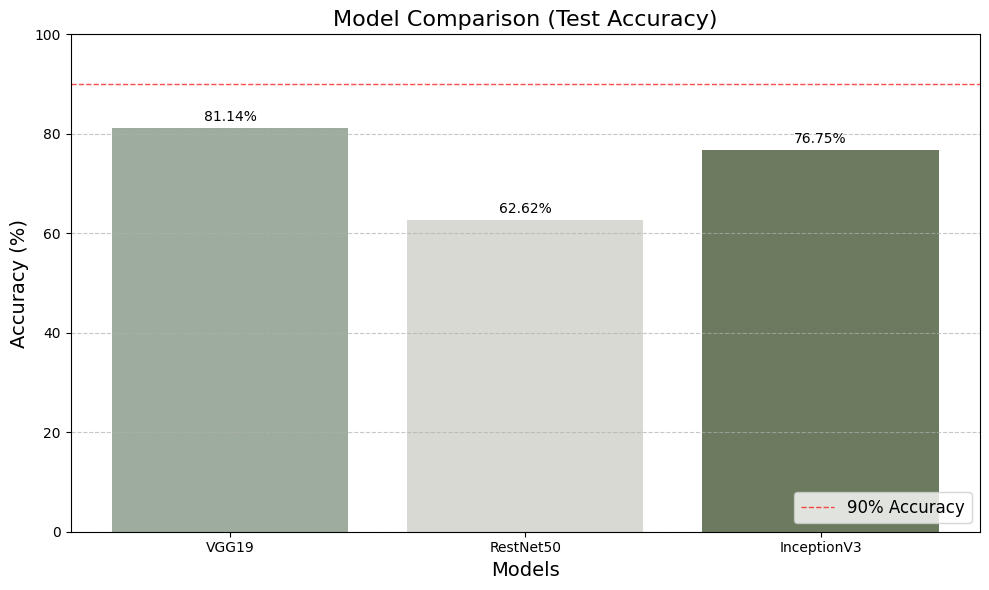

In [2]:
import matplotlib.pyplot as plt
models = ['VGG19', 'RestNet50', 'InceptionV3']
accuracy = [81.14, 62.62, 76.75]
colors = ['#9DAC9C', '#D8D9D2', '#6C7B5F']
fig, ax = plt.subplots(figsize=(10, 6))
bars = plt.bar(models, accuracy, color=colors)
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height}%', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')
plt.title("Model Comparison (Test Accuracy)", fontsize=16)
plt.xlabel("Models", fontsize=14)
plt.ylabel("Accuracy (%)", fontsize=14)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.axhline(y=90, color='r', linestyle='--', linewidth=1, alpha=0.7)
plt.legend(['90% Accuracy'], loc='lower right', fontsize=12)
plt.tight_layout()
plt.show()


# Evaluation metrics for each model

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

models = ['VGG19', 'ResNet50', 'InceptionV3']
accuracy = [vgg19_accuracy, resnet50_accuracy, inceptionv3_accuracy]
precision = [vgg19_precision, resnet50_precision, inceptionv3_precision]
recall = [vgg19_recall, resnet50_recall, inceptionv3_recall]
f1_score = [vgg19_f1_score, resnet50_f1_score, inceptionv3_f1_score]


x = np.arange(len(models))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - 1.5*width, accuracy, width, label='Accuracy')
rects2 = ax.bar(x - 0.5*width, precision, width, label='Precision')
rects3 = ax.bar(x + 0.5*width, recall, width, label='Recall')
rects4 = ax.bar(x + 1.5*width, f1_score, width, label='F1 Score')

ax.set_ylabel('Scores')
ax.set_title('Model Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

fig.tight_layout()

plt.show()


# Comparison Conclusion for Cassava Leaf Disease Classification

The performance of three different deep learning models, namely VGG19, ResNet50, and InceptionV3, was evaluated for the classification of cassava leaf disease. Here's a summary of the findings:

VGG19: VGG19 achieved the highest accuracy among the three models, with an accuracy of 81.14%. This model demonstrated robust performance in distinguishing between different classes of cassava leaf diseases.
ResNet50: ResNet50 exhibited a moderate accuracy of 62.62%. While not as accurate as VGG19, ResNet50 still showcased decent performance in classifying cassava leaf diseases.
InceptionV3: InceptionV3 achieved an accuracy of 76.75%, positioning it between VGG19 and ResNet50 in terms of performance. It demonstrated good capability in classifying cassava leaf diseases but fell slightly short compared to VGG19.
In conclusion, VGG19 emerges as the top-performing model for cassava leaf disease classification, closely followed by InceptionV3, while ResNet50 lags behind in terms of accuracy. However, it's essential to consider other factors such as computational efficiency and model complexity when selecting the most suitable model for deployment in real-world scenarios.